# Image C3171 Mosaic

A quick notebook to look at extracting the pixel size and FWHM of the synthesised beam given a set of uv files to image. Unlike the previous notebook, this will attempt to use the robust interpolation code from the 'Generate_Image_Parameters_Interpolation_Robustness' notebook to minimise the efects of the convol step. 

The idea is to use the look up table to get a near consistent resolution to begin with, and then convol the final step as little as possible. 

This notebook attempts to implement a clobber like feature, where if the outputs exist then thay will be skipped. This will be very helpful so that I wouln't have to rerun the entire pipeline, yet should still be able to build up the datastructure to include extra steps. 

In [1]:
%matplotlib inline
import os
import sys
import glob
import shutil
import numpy as np
import pandas as pd
import subprocess as sp
import matplotlib.pyplot as plt

from astropy.io import fits as pyfits
from scipy.interpolate import interp1d

from dask import delayed
from dask.diagnostics import ProgressBar

import dask

In [19]:
# # Constants for the reduction for robust=2
CELL = '0.4'
RES = 4.5
AXIS='maj'
ROBUST = '2'
FWHM = '5.5,3.'
PA = '0.'
OFFSET = '3:32:22.0,-27:48:37'
SELFCAL = 4
SYSTEMP=False

# # # Constants for the reduction for robust=2
# CELL = '0.48,0.92'
# ROBUST = '2'
# FWHM = '4.8,2.5'
# PA = '2.2'
# OFFSET = '3:32:22.0,-27:48:37'
# SELFCAL = 0

# Constants for the reduction for robust=0.5
# CELL = '0.48,0.92'
# ROBUST = '0.5'
# FWHM = '3.7,1.45'
# PA = '2.2'
# OFFSET = '3:32:22.0,-27:48:37'
# SELFCAL = 4

# # Constants for the reduction robust=-0.5
# CELL = '0.48,0.92'
# ROBUST = '-0.5'
# FWHM = '2.3,0.9'
# PA = '2.2'
# OFFSET = '3:32:22.0,-27:48:37'
# SELFCAL = 6

In [20]:
data = '../Data/Days1-10_v2/*uv'
files = glob.glob(data)
files = files


print(f'Found {len(files)} to image')
out_dir = '../Data/Days1-10_v2/Image_Higher'

rob_df = pd.read_json('DF_Interpolation.json')
rob_df_systemp = pd.read_json('DF_Interpolation_systemp.json')
print('Loaded the robust interpolation DataFrame')
print(rob_df.shape)

print('Loaded the robuster interpolation DataFrame with systempt weighting')
print(rob_df_systemp.shape)

Found 195 to image
Loaded the robust interpolation DataFrame
(2340, 58)
Loaded the robuster interpolation DataFrame with systempt weighting
(2340, 58)


In [4]:
def task_str(task, kw, execute=False):
    '''Return a string to pass to subprocess run args
    task - str, the name of the task
    kw - dict, the dictionary to parse
    '''
    task = ' '.join([task]+[f'{key}={val}' for key, val in kw.items()])

    if execute:
        return run_str(task)
    else:
        return task
    
def run_str(task):
    '''Given an task string, execute it and return the subproces result
    task - str, the string produced by task_str() or equiviliant
    '''
    return sp.run(args=task, stdout=sp.PIPE, stderr=sp.PIPE, shell=True, check=True)

In [5]:
def return_robust(n, res, axis=AXIS, systemp=False):
    '''Function to return the appropriate robust for a pointing given a desired resolution.
    n - str, name of the pointing thsat is currently being imaged
    res - float, the desired resolution
    axis - str, acceptable values maj or min denote the desired axis to model
    systemp - bool, whether to use the systemp robust interpolation dataframe or the normal
    '''
    
    if systemp:
        rdf = rob_df_systemp
    else:
        rdf = rob_df
    
    if axis not in ['min','maj']:
        print(f'Axis {axis} not supported')
        return 2
    
    sub_df = rdf[rdf['name'] == n]
    rob_plt = np.linspace(-2,2,1000)
    
    rob_val = sub_df['robust'].values
    if axis == 'min':
        size = sub_df['bmin'].values
    else:
        size = sub_df['bmaj'].values
        
    interp = interp1d(rob_val, size, kind='cubic', assume_sorted=False)
    
    return rob_plt[np.argmin(np.abs(interp(rob_plt) - res))]

In [ ]:
def start_up(out_dir=out_dir):
    '''Common steps to set up the processing
    '''
    if not os.path.exists(out_dir):
        print('Creating output directory...')
        os.mkdir(out_dir)

def close_down(out_dir=out_dir):
    '''Common steps to close down the processing
    '''
    if os.path.exists(out_dir):
        print(f'Deleting the output directory {out_dir}')
        shutil.rmtree(out_dir)

def file_out(name, out_dir=out_dir,self_rnd=None):
    '''A consistent method on crafting a filename for each task. Will
    append the name to the out_dir, as well as any extra requested options,
    like selfcal appending, and folder locations if needed
    
    name - str, name of the file/folder to make
    out_dir - str, name of the output folder
    self_rnd - int or None, the self calibration round currently up to
    '''
    if self_rnd is not None:
        out_dir = f'{out_dir}/Self_{self_rnd}'
        if not os.path.exists(out_dir):
            try:
                os.makedirs(out_dir)
            except OSError:
                pass

    return f'{out_dir}/{name}'

def get_val(k, key, self_rnd=None):
    '''A helper function to get the appropriate key value from dictionary
    produced by the pipeline
    
    k - dict, the dictionary produced by the pipeline
    key - str, the string of the key to extract
    self_rnd - int or None, the current self calibration round
    '''
    if self_rnd is not None:
        key = f'{key}_self{self_rnd}'
    
    return k[key]

def set_val(k, key, val, self_rnd=None):
    '''A helper function to consistently set values to the dictionary populated
    by the pipeline while being aware of the self-calibration round
    
    k - dict, the dictionary produced by the pipeline
    key - str, the key to add
    val - object, item to add to the dictionary
    rnd - int or None, the self calibration round
    '''
    if self_rnd is not None:
        key = f'{key}_self{self_rnd}'
    
    k[key] = val
    
    return k

def exists(f):
    '''A small helper function to test to see if a file or folder exists. Keep it
    as a separate unction incase extra logic needs to be built up.
    f - str, the path to the file or folder to check
    '''
    return os.path.exists(f)

@delayed
def get_name(uv):
    '''Make up the name of the pointing consistently
    '''
    return uv.split('/')[-1]
    
@delayed
def invert(uv, res=RES, cell=CELL, offset=OFFSET, imsize='3,3,beam', name=None, self_rnd=None, kw=None, systemp=False, skip=True):
    '''Call the Miriad Invert task to make up the beam
    uv - str, name of the uv file to image
    res - float, the desired resolution that is passed to the robust interpolation function
    cell - str, the cell sizes to be used
    offset - str, the RA and DEC position to use for reference pixel
    imsize - str, the image size that will be passed directly to invert
    name - str or None, the source name, try to figure it out if none
    out_dir - str, where to write the output files
    self_rnd - int or None, the self calibration round
    kw - dict or None, if self calibration round, then kw is the dict up to that point otherwise None
    skip - bool, attempt to skip the task if the outputs already exists
    '''
    if name is None:
        name = get_name(uv)
        print(f'name of {uv} is {name}')
    
    i_map = file_out(f'{name}.map', self_rnd=self_rnd)
    i_beam = file_out(f'{name}.beam', self_rnd=self_rnd)
    
    i_options = 'mfs,double,sdb,mosaic,systemp' if systemp is True else 'mfs,double,sdb,mosaic'

    # if self calibrated, overwrite the supplied uv file
    if self_rnd is not None:
        uv = get_val(kw, 'vis', self_rnd=self_rnd)
    
    robust = return_robust(name, res, systemp=systemp)
        
    invert_kw = {'vis':uv, 'robust':robust, 'options':i_options,
                            'beam': i_beam, 'map': i_map, 'offset':offset, 
                            'cell':cell, 'stokes':'i', 'imsize':imsize}
    
    if (skip and not exists(i_map)) or not skip:
        p = task_str('invert', invert_kw, execute=True)
        
    if kw is None:
        kw = invert_kw
        kw['name'] = name
    else:
        kw = set_val(kw, 'map', i_map, self_rnd=self_rnd)
        kw = set_val(kw, 'beam', i_beam, self_rnd=self_rnd)
    return kw

@delayed
def stokes_v_rms(k, self_rnd=None, skip=True):
    '''Given a uv file, work out the RMS from the stokes v image
    k - dict, containing the results of the processing up to this point
    skip - bool, attempt to skip if the outputs exists
    '''
    name = k['name']
    vis = get_val(k, 'vis', self_rnd=self_rnd)
    v_map = file_out(f'{name}.v.map', self_rnd=self_rnd)

    if (skip and not exists(v_map)) or not skip:
        p = task_str('invert', {'vis':k['vis'], 'options':k['options'], 'stokes':'v',
                                'map':v_map, 'robust':k['robust']},
                    execute=True)

    p1 = task_str('sigest', {'in':v_map}, execute=True)
    
    for l in p1.stdout.decode('utf-8').split('\n'):
        if 'Estimated rms' in l:
            items = l.split()
            k = set_val(k, 'v_rms', float(items[3]), self_rnd=self_rnd)
    
    return k

@delayed
def mfclean(k, sigma=5, self_rnd=None, skip=True):
    '''Function to clean the image, given the outouts from invert and the
    stokes_v_rms function. 
    
    k - dict, results thus far from the pipeline
    out_dir - str, where to save the clean components
    sigma - int, how deep to clean
    self_rnd, int or None, the self calibration round
    skip - bool, attempt to skip the task if it already exists
    '''
    name = k['name']
    out = file_out(f'{name}.clean', self_rnd=self_rnd)
    cutoff = sigma * get_val(k, 'v_rms')
    
    i_map = get_val(k, 'map', self_rnd=self_rnd)
    i_beam = get_val(k, 'beam', self_rnd=self_rnd)
     
    if (skip and not exists(out)) or not skip:
        p = task_str('mfclean', {'map':i_map, 'beam':i_beam, 'region':'perc\(66\)',
                                 'niters':'1000,100', 'cutoff':cutoff, 'out':out},
                    execute=True)

    k = set_val(k, 'mfclean_model', out, self_rnd=self_rnd)
    
    return k

@delayed
def fit_beam(k, self_rnd=None):
    '''Fit to the beam to obtain a FWHM
    k - dict, contains output from invert and itemise
    '''
    
    b = get_val(k, 'beam', self_rnd=self_rnd)

    p = task_str('imfit', {'in':f'{b}', 'object':'beam', 'region':'perc\(1\)\(1\)'},
                 execute=True)
    
    
    if p.stdout is not None:
        for line in p.stdout.decode('utf-8').split('\n'):
            if 'Major axis' in line:
                items = line.split()
                k = set_val(k, 'bmaj', float(items[3]), self_rnd=self_rnd)
                k = set_val(k, 'bmaj_e', float(items[5]), self_rnd=self_rnd)
            elif 'Minor axis' in line:
                items = line.split()
                k = set_val(k, 'bmin', float(items[3]), self_rnd=self_rnd)
                k = set_val(k, 'bmin_e', float(items[5]), self_rnd=self_rnd)
            elif 'Position angle' in line and not 'Beam' in line and not 'Deconvol' in line:
                items = line.split()
                k = set_val(k, 'pa', float(items[3]), self_rnd=self_rnd)
                k = set_val(k, 'pa_e', float(items[5]), self_rnd=self_rnd)
                           
    k = set_val(k , 'imfit_stdout', p.stdout.decode('utf-8'), self_rnd=self_rnd)
    k = set_val(k , 'imfit_stderr', p.stderr.decode('utf-8'), self_rnd=self_rnd)
                               
    return k

@delayed
def restor(k, self_rnd=None, skip=True):
    '''Restor a map given the cleaned model
    self_rnd - int or None, the self calibration round
    skup - bool, attempt to skip if the outputs already exists 
    '''
    name = k['name']
    out = file_out(f'{name}.restor', self_rnd=self_rnd)
    i_map = get_val(k, 'map', self_rnd=self_rnd)
    i_beam = get_val(k, 'beam', self_rnd=self_rnd)
    i_model = get_val(k, 'mfclean_model', self_rnd=self_rnd)
    bmaj = get_val(k, 'bmaj', self_rnd=self_rnd)
    bmin = get_val(k, 'bmin', self_rnd=self_rnd)
    pa = get_val(k, 'pa', self_rnd=self_rnd)
    
    if (skip and not exists(out)) or not skip:
        p = task_str('restor', {'map':i_map, 'beam':i_beam, 'model':i_model,
                                'out':out, 'options':'mfs', 'fwhm':f'{bmaj},{bmin}',
                                'pa':f'{pa}'},
                     execute=True)
    
    k = set_val(k, 'restor', out, self_rnd=self_rnd)
    
    return k


    
@delayed(nout=len(files))
def linmos(items, temp='linmos_temp.dat', file_name='all_days', self_rnd=None):
    '''Linmos all the restored images together
    items - list of dicts, contains all the outputs of the pipeline thus far
    '''
    if self_rnd == 0:
        self_rnd = None
    if self_rnd is not None:
        temp = f'{temp}_self{self_rnd}'
        file_name = f'{file_name}_self{self_rnd}'
    with open(f'{temp}','w') as f:
        for k in items:
#             print(get_val(k, 'restor', self_rnd=self_rnd),file=f)
            print(get_val(k, 'convol', self_rnd=self_rnd),file=f)
    
    out = file_out(f'{file_name}.linmos', self_rnd=self_rnd)
    p = task_str('linmos', {'in':f'@{temp}', 'bw':'4.096', 'out':out}, execute=True)
    
    return items
  
@delayed
def self_uvaver(k, self_rnd=None, skip=True):
    '''Perform the required uvaver on a dataset to apply the calibration tables that
    is required before selcal can be used
    
    k - dict, results of processing up to this point
    self_cal - int, the self calibration round number
    skip - bool, attempt to skip if the outputs already exist
    '''
    # Get the input visibility file
    if self_rnd == 1:
        in_vis = k['vis']
    else:
        prev_rnd = self_rnd - 1
        in_vis = get_val(k, 'vis', self_rnd=self_rnd - 1)
    
    name = k['name']
    out = file_out(f'{name}_self{self_rnd}.vis', self_rnd=self_rnd)

    if (skip and not exists(out)) or not skip:
        p = task_str('uvaver', {'vis':in_vis, 'out':out}, execute=True)
    
    set_val(k, 'vis', out, self_rnd=self_rnd)
    return k
    
@delayed
def selfcal(k, self_rnd, options='mfs,phase', interval='0.1', skip=True, amp_test=False):
    '''Run the self calibration task given a model and visibility file
    
    k - dict, dictionary produced by the pipeline
    self_rnd - int, the current self calibration round
    options - str, options passed directly to selfcal
    interval - int, the length of time for new solutions
    skip - bool, attempt to skip if outputs already exist
    amp_test - attempt to use statistics from the restor map 
               to decide whether amplitude selfcal should be used
    '''
    
    vis = get_val(k, 'vis', self_rnd=self_rnd)
    if self_rnd == 1:
        model = k['mfclean_model']
    else:
        model = get_val(k, 'mfclean_model', self_rnd=self_rnd-1)
    
    if amp_test:
        if self_rnd == 1:
            restor_max = k['restor_max']
        else:
            restor_max = get_val(k, 'restor_max', self_rnd=self_rnd-1)
        
        if restor_max > 0.005:
            print('Attempting amplitude Selfcal for ', vis, restor_max)
            options= 'mfs,amp'
            interval = '1'
    
    # Self cal only adds files to the miriad folder
    if (skip and not exists(f'{vis}/gains')) or not skip:
        p = task_str('selfcal', {'vis':vis, 'model': model, 'options':options, 'interval':interval,
                                'nfbin':'4'},
                     execute=True)

        if 'amp' in options:
            for s in ['xx,yy','yy,xx','xy,yx','yx,xy']:
                flagpar='10,10,0,3,4,3,20'
                pgflag_kw = {'vis':vis, 'stokes':s, 'options':'nodisp', 'command':r'\<b'}
                pgflag_str = ' '.join(['pgflag']+[f'{key}={val}' for key, val in pgflag_kw.items()])
                p = sp.run(args=pgflag_str, shell=True, stdout=sp.PIPE, stderr=sp.PIPE)
                print(p.stdout.decode('utf-8'))
                print(p.stderr.decode('utf-8'))
        
        
        k = set_val(k, f'selfcal_{self_rnd}_stdout', p.stdout.decode('utf-8'))
        k = set_val(k, f'selfcal_{self_rnd}_stderr', p.stderr.decode('utf-8'))
    
    return k

@delayed
def restor_stats(k, self_rnd=None, skip=True):
    '''A initial function to investigate how to get out statistics to decide whether to 
    amplitude self calibrate
    k - dict, the dictionary that is being populated throughout the processing
    self_rnd - int or None, The iteration of self calibration, None if no self calibration
    skip - bool, attempt to skip if outputs exist
    '''
    
    res = get_val(k, 'restor', self_rnd=self_rnd)
    fits = f'{res}.fits'
    
    if (skip and not exists(fits)) or not skip:
        p = task_str('fits', {'in':res, 'out':fits, 'op':'xyout','region':'images\(1,1\)'}, execute=True)
    
    data = pyfits.open(fits)[0].data.squeeze()
    mask = data > 0.
    k = set_val(k, 'restor_max', data.max(), self_rnd=self_rnd)
    k = set_val(k, 'restor_min', data.min(), self_rnd=self_rnd)
    k = set_val(k, 'restor_sum', data.sum(), self_rnd=self_rnd)
    k = set_val(k, 'restor_sum_positive', data[mask].sum(), self_rnd=self_rnd)
    k = set_val(k, 'restor_std', data.std(), self_rnd=self_rnd)
    
    return k

@delayed
def format_results(items):
    '''Process the outputs from the Dask pipeline
    '''
    return pd.DataFrame(items)

In [ ]:
# close_down()
# start_up()

SKIP = True
AMP_TEST = False

names = [get_name(f) for f in files]
kw  = [invert(f, name=n, systemp=SYSTEMP, skip=SKIP) for f, n in zip(files, names)]
kw  = [stokes_v_rms(k, skip=SKIP) for k in kw]
kw  = [mfclean(k, skip=SKIP, sigma=10) for k in kw]
kw  = [fit_beam(k) for k in kw]
kw  = [restor(k, skip=SKIP) for k in kw]
kw  = [restor_stats(k, skip=SKIP) for k in kw] 

if SELFCAL > 0:
    sigma_range = np.linspace(10, 3, SELFCAL)
    for i in range(1, SELFCAL+1):
        kw = [self_uvaver(k, self_rnd=i, skip=SKIP) for k in kw]
        kw = [selfcal(k, i, skip=SKIP, amp_test=(AMP_TEST and i == SELFCAL)) for k in kw]

        imsize = '5,5,beam' if i == 10 else '3,3,beam'
        
        kw = [invert(f, imsize=imsize, name=n, self_rnd=i, kw=k, systemp=SYSTEMP, skip=SKIP) for f, n, k in zip(files, names, kw)]
        kw = [mfclean(k, self_rnd=i, sigma=sigma_range[i-1], skip=SKIP) for k in kw]
        kw = [fit_beam(k, self_rnd=i) for k in kw]
        kw = [restor(k, self_rnd=i, skip=SKIP) for k in kw]
        kw = [restor_stats(k, self_rnd=i, skip=SKIP) for k in kw] 

with ProgressBar():
    df = format_results(kw).compute(num_workers=15)

[                                        ] | 0% Completed |  1min 22.4s

/mnt/software/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


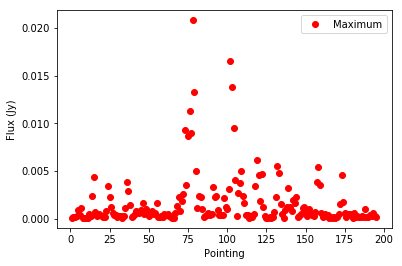

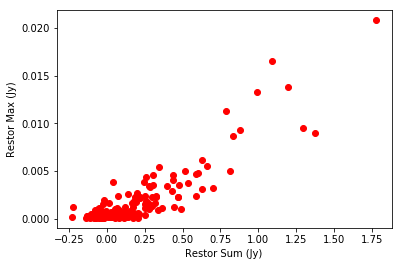

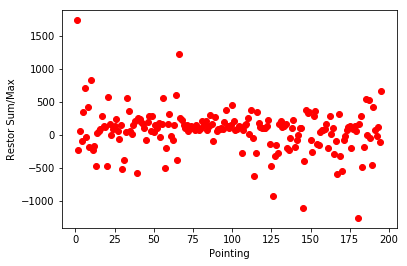

In [13]:
df['pointing'] = pd.to_numeric(df['name'].str.replace('c3171_','').str.replace('.uv',''))

fig, ax = plt.subplots(1,1)

ax.plot(df['pointing'], df['restor_max'], 'ro', label='Maximum')
ax.legend()
ax.set(xlabel='Pointing', ylabel='Flux (Jy)')
fig.show()

fig, ax = plt.subplots(1,1)

ax.plot(df['restor_sum'], df['restor_max'], 'ro')
ax.set(xlabel='Restor Sum (Jy)', ylabel='Restor Max (Jy)')
fig.show()

fig, ax = plt.subplots(1,1)

ax.plot(df['pointing'], df['restor_sum']/df['restor_max'], 'ro')
ax.set(xlabel='Pointing', ylabel='Restor Sum/Max')
fig.show()

In [14]:
df

,beam,beam_self1,beam_self2,beam_self3,beam_self4,bmaj,bmaj_e,bmaj_e_self1,bmaj_e_self2,bmaj_e_self3,...,selfcal_4_stderr,selfcal_4_stdout,stokes,v_rms,vis,vis_self1,vis_self2,vis_self3,vis_self4,pointing
0,../Data/Days1-10_v2/Image_Higher/c3171_6.uv.beam,../Data/Days1-10_v2/Image_Higher/Self_1/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_2/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_3/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_4/c3171_...,4.406,0.068,0.068,0.068,0.068,...,### Warning: Intervals with no solution: 2\n,"\nselfcal: Revision 1.19, 2016/01/28 22:07:15 ...",i,0.000021,../Data/Days1-10_v2/c3171_6.uv,../Data/Days1-10_v2/Image_Higher/Self_1/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_2/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_3/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_4/c3171_...,6
1,../Data/Days1-10_v2/Image_Higher/c3171_1.uv.beam,../Data/Days1-10_v2/Image_Higher/Self_1/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_2/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_3/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_4/c3171_...,4.404,0.067,0.067,0.067,0.067,...,### Warning: Intervals with no solution: 1\n#...,"\nselfcal: Revision 1.19, 2016/01/28 22:07:15 ...",i,0.000020,../Data/Days1-10_v2/c3171_1.uv,../Data/Days1-10_v2/Image_Higher/Self_1/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_2/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_3/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_4/c3171_...,1
2,../Data/Days1-10_v2/Image_Higher/c3171_5.uv.beam,../Data/Days1-10_v2/Image_Higher/Self_1/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_2/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_3/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_4/c3171_...,4.428,0.068,0.068,0.068,0.068,...,### Warning: Intervals with no solution: 1\n,"\nselfcal: Revision 1.19, 2016/01/28 22:07:15 ...",i,0.000021,../Data/Days1-10_v2/c3171_5.uv,../Data/Days1-10_v2/Image_Higher/Self_1/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_2/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_3/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_4/c3171_...,5
3,../Data/Days1-10_v2/Image_Higher/c3171_21.uv.beam,../Data/Days1-10_v2/Image_Higher/Self_1/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_2/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_3/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_4/c3171_...,4.391,0.067,0.068,0.068,0.068,...,### Warning: Intervals with no solution: 1\n#...,"\nselfcal: Revision 1.19, 2016/01/28 22:07:15 ...",i,0.000022,../Data/Days1-10_v2/c3171_21.uv,../Data/Days1-10_v2/Image_Higher/Self_1/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_2/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_3/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_4/c3171_...,21
4,../Data/Days1-10_v2/Image_Higher/c3171_17.uv.beam,../Data/Days1-10_v2/Image_Higher/Self_1/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_2/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_3/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_4/c3171_...,4.418,0.066,0.066,0.067,0.066,...,### Warning: Intervals with no solution: 1\n,"\nselfcal: Revision 1.19, 2016/01/28 22:07:15 ...",i,0.000022,../Data/Days1-10_v2/c3171_17.uv,../Data/Days1-10_v2/Image_Higher/Self_1/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_2/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_3/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_4/c3171_...,17
5,../Data/Days1-10_v2/Image_Higher/c3171_2.uv.beam,../Data/Days1-10_v2/Image_Higher/Self_1/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_2/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_3/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_4/c3171_...,4.412,0.068,0.068,0.068,0.068,...,### Warning: Intervals with no solution: 1\n,"\nselfcal: Revision 1.19, 2016/01/28 22:07:15 ...",i,0.000021,../Data/Days1-10_v2/c3171_2.uv,../Data/Days1-10_v2/Image_Higher/Self_1/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_2/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_3/c3171_...,../Data/Days1-10_v2/Image_Higher/Self_4/c3171_...,2
6,../Data/Days1-10_v2/Ima

In [21]:
@delayed
def linmos_delayed(temp='linmos_temp.dat', mode='convol', file_name='all_days', self_rnd=None):
    '''Linmos all the restored images together
    items - list of dicts, contains all the outputs of the pipeline thus far
    '''
    if mode not in ['restor','convol']:
        return
    if self_rnd == 0:
        self_rnd = None
    if self_rnd is not None:
        temp = f'{temp}_self{self_rnd}'
        file_name = f'{file_name}_s{self_rnd}'
    temp = f'{temp}_{mode}'
    with open(f'{temp}','w') as f:
        for k in glob.glob(file_out('*convol', self_rnd=self_rnd)):
            print(k,file=f)
    
    out = file_out(f'{file_name}.{mode}.linmos', self_rnd=self_rnd)
    
    if os.path.isdir(out):
        shutil.rmtree(out)
    
    p = task_str('linmos', {'in':f'@{temp}', 'bw':'4.096', 'out':out}, execute=True)
    
    return self_rnd

In [22]:
@delayed
def convol(k, fwhm=FWHM, pa=PA, self_rnd=None):
    '''Convol each of the restored image to a common resolution. 
    fwhm - str, the FWHM to convole to that is passed directly to convol
    pa - str, the pa to convole to that is passed directly to convol
    self_rnd - int or None, the self calibration round
    '''
    if self_rnd == 0:
        self_rnd = None
        
    name = k['name']
    out = file_out(f'{name}.convol', self_rnd=self_rnd)
    i_map = get_val(k, 'restor', self_rnd=self_rnd)
    
    if os.path.isdir(out):
        shutil.rmtree(out)
    
    p = task_str('convol', {'map':i_map, 'fwhm':fwhm, 'pa':pa,
                            'out':out, 'options':'final'},
                 execute=True)
    
    k = set_val(k, 'convol', out, self_rnd=self_rnd)
    
    return k

In [23]:
vals = [ convol(k,self_rnd=s) for s in range(0,SELFCAL+1) 
                              for i,k in df.iterrows() ]
with ProgressBar():
    ndf = format_results(vals).compute(num_works=15)

[########################################] | 100% Completed |  6min 37.2s


In [27]:
vals = [ linmos_delayed(self_rnd=s, mode=m) for s in range(0,SELFCAL+1) 
                                            for m in ['convol']]    
with ProgressBar():
    ldf = format_results(vals).compute(num_works=10)

[                                        ] | 0% Completed |  0.4s


CalledProcessError: Command 'linmos in=@linmos_temp.dat_self3_convol bw=4.096 out=../Data/Days1-10_v2/Image_Higher/Self_3/all_days_s3.convol.linmos' returned non-zero exit status 1.

In [25]:
df.to_csv('Image_Output.csv')